4 nodes on month: 2 hour 40 minutes

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import dask

from xgcm import Grid

from rechunker import rechunk

from pathlib import Path

import shutil

from Routines import utilities
from Routines import filtres

import Modal_matrix

In [2]:
from dask.distributed import Client, wait, LocalCluster
from dask_jobqueue import PBSCluster

if True:
    cluster = PBSCluster(walltime="05:00:00")
else:
    tmp_wrk = "/home/datawork-lops-osi/equinox/enatl60/adrien/tmp"
    cluster = LocalCluster(local_directory=tmp_wrk)
client = Client(cluster)
client 

<Client: 'tcp://10.148.1.93:51516' processes=0 threads=0, memory=0 B>

# LOADING INITIAL DATASET

In [3]:
%%time
cluster.scale(jobs=1)

grid = utilities.get_eNATL60_grid()

CPU times: user 136 ms, sys: 20 ms, total: 156 ms
Wall time: 1.55 s


# Datapath

In [4]:
datapath_data_preprocessed = Path('/home/datawork-lops-osi/equinox/enatl60/adrien/data_preprocessed/')
datapath_result = Path('/home/datawork-lops-osi/equinox/enatl60/adrien/results/')
datapath_modes_corrections = Path('/home/datawork-lops-osi/equinox/enatl60/vmodes_and_global-mean/')
data_path_temp = Path('/home3/scratch/abella/temp/')
data_path_temp_rechunk = Path('/home3/datawork/abella/temp/')

# Parametre

In [5]:
Month = 1



# DOMAIN

# need the .5 at the superior end because of x_r and y_r, if you want then to have the same number of point as x_c and y_c
Domain_Sahara_dict = dict(x=slice(4200, 5200.5), y=slice(400,1400.5))
Domain_Caraibe_dict = dict(x=slice(1100, 2300.5), y=slice(300,1100.5))
Domain_Gulfstream_dict = dict(x=slice(1300, 2800.5), y=slice(1800,2700.5))
Domain_Azores_dict = dict(x=slice(3600, 4500.5), y=slice(1400,2300.5))
Domain_North_Atlantic_dict = dict(x=slice(0,8354.5), y=slice(0,4729.5))
Domain_Bay_of_Biscay_dict = dict(x=slice(4600, 5800.5), y=slice(2400,3200.5))
Domain_Nordic_Europe_dict = dict(x=slice(4600,5600.5), y=slice(3300,4600.5))
Domain_Labrador_dict = dict(x=slice(1900, 3400.5), y=slice(3600,4700.5))

Dict_domain = ({'Gulf_Stream' : Domain_Gulfstream_dict, 'Azores' : Domain_Azores_dict, 'North_Atlantic' : Domain_North_Atlantic_dict, 
                'Nordic_Europe' : Domain_Nordic_Europe_dict, 'Sahara' : Domain_Sahara_dict, 'Caraibe' : Domain_Caraibe_dict,
               'Bay_of_Biscay' : Domain_Bay_of_Biscay_dict, 'Labrador' : Domain_Labrador_dict})

    

#Domain = 'Azores'
#Domain = 'Gulf_Stream'
#Domain = 'Nordic_Europe'
#Domain = 'Labrador'
Domain = 'North_Atlantic'


### Number of nodes to run different kind of operations:
large_computation_nodes_number = 4

# CHUNKING

In [6]:
### CHUNKING PARAMETERS
ch_h_main = 200
ch_v_main = 30
ch_t_main = 31
ch_mode = -1


grid = utilities.Domain_selection(grid, Domain, Dict_domain)
grid = grid.chunk({'x_c' : ch_h_main, 'x_r' : ch_h_main, 'y_c' : ch_h_main, 'y_r' : ch_h_main})

max_mem = '3GB' #Max of memory per core allocated to the rechunking operation. 
#Do not excess the worker RAM capacity (nor get too near) 4 core by worker. So max 3GB

# Xgrid building

In [7]:
Aus = xr.open_zarr(datapath_data_preprocessed/"Aus_corr_month_{}.zarr".format(Month))
Aus = utilities.Domain_selection(Aus, Domain, Dict_domain)


DataGrid = xr.merge([grid, Aus])
xgrid = Grid(DataGrid, periodic=None)

# Vertical velocity comptation routines

In [8]:
def div_velocities(data_u, data_v, ch_h, ch_h_store, e1t, e2t, e1v, e2u, xgrid, datapath_temp):

    step = 400
    
    
    ### Computation of the velocity horizontal divergence
    duu = xgrid.diff(data_u * e2u, 'X', boundary="extend").chunk({"x_c":ch_h})
    duu = duu/(e1t * e2t)
    utilities.storage_by_step(duu, 'duu', "duu.zarr", step, {"x_c":ch_h_store, "y_c":ch_h_store}, datapath_temp)  
    
    dvv = xgrid.diff(data_v * e1v, 'Y', boundary="extend").chunk({"y_c":ch_h})
    dvv = dvv/(e2t * e1t)  
    utilities.storage_by_step(dvv, 'dvv', "dvv.zarr", step, {"x_c":ch_h_store, "y_c":ch_h_store}, datapath_temp)  
    


In [9]:
def initial_vertical_modes_rechunk(ch_h_store, ch_v_store, Phiu, Phiv, Phi, datapath_temp):

    
    # Preliminary rechunking of vertical modes, chunking : -11 on "modm", 1 on "mode"
    utilities.rechunk_warper(Phi.to_dataset(name='Phi'), {'z_c': ch_v_store, 'x_c': ch_h_store, 'y_c': ch_h_store, 'mode': 1}, max_mem, datapath_temp/'Phi_prov.zarr', datapath_temp/'Phi_temp.zarr')
    print('Phi')
    
    utilities.rechunk_warper(Phiu.to_dataset(name='Phi'), {'z_c': ch_v_store, 'x_r': ch_h_store, 'y_c': ch_h_store, 'mode' : -1}, max_mem, datapath_temp/'Phiu_prov.zarr', datapath_temp/'Phi_temp.zarr')
    print('Phiu')
    
    utilities.rechunk_warper(Phiv.to_dataset(name='Phi'), {'z_c': ch_v_store, 'x_c': ch_h_store, 'y_r': ch_h_store, 'mode' : -1}, max_mem, datapath_temp/'Phiv_prov.zarr', datapath_temp/'Phi_temp.zarr')
    print('Phiv')

In [10]:
def first_correction_term_preliminary(comp, Phi, Vmodes, field, ch_h, ch_v, ch_h_store, ch_v_store, horizontal_metric, e3t, vertical_metric, xgrid, datapath_temp, mask):
    # field : data_u or data_v
    # horizontal_metric : e2u or e1v
    # vertical metric : e3u or e3v
    # comp : X or Y
    # mask : umask or vmask
    
    ntom = {"mode":"modm"}
    

    
    
    ### Computation of the first correction term
    
    if comp == 'X':
        horizontal_coord = 'x_c'
    if comp == 'Y':
        horizontal_coord = 'y_c'
    
    
    
    
    field = field.chunk({"mode":-1})
    An = xgrid.diff(horizontal_metric * field.rename(ntom), comp, boundary="extend").chunk({horizontal_coord:ch_h})
    An = An.chunk({"x_c": ch_h_store, "y_c": ch_h_store}) 
    An.to_dataset(name='An').to_zarr(datapath_temp/"An.zarr", compute=True, mode='w')
    Pn = xgrid.interp(vertical_metric * Vmodes.rename(ntom), comp, boundary="extend").chunk({horizontal_coord:ch_h})
    Pn = Pn.chunk({"x_c": ch_h_store, "y_c": ch_h_store, "z_c": ch_v_store})
    Pn.to_dataset(name='Pn').to_zarr(datapath_temp/"Pn.zarr", compute=True, mode='w')
    
    
    Pn = xr.open_zarr(datapath_temp/"Pn.zarr")
    Pn = Pn.Pn.chunk({"x_c": ch_h, "y_c": ch_h, "z_c": ch_v})
    A = (Pn - Phi.chunk({"mode":-1}).rename(ntom) * e3t)
    A = A.chunk({"x_c": ch_h_store, "y_c": ch_h_store, "z_c": ch_v_store})
    A.to_dataset(name='A').to_zarr(datapath_temp/"A.zarr", compute=True, mode='w')
    shutil.rmtree(datapath_temp/"Pn.zarr")


    


In [11]:
def first_correction_term(comp, Phi, ch_h, ch_v, ch_h_store, e1t, e2t, e3t, datapath_temp):
    # comp : X or Y
    
    A = xr.open_zarr(datapath_temp/"A.zarr")
    A = A.A.chunk({"x_c": ch_h, "y_c": ch_h, "z_c": ch_v})
    
    An = xr.open_zarr(datapath_temp/"An.zarr")
    An = An.An.chunk({"x_c": ch_h, "y_c": ch_h})
    
    
    Div_cor = 1/e3t * A
    Div_cor = Div_cor.chunk({"x_c": ch_h_store, "y_c": ch_h_store})
    Div_cor.to_dataset(name='Div_cor').to_zarr(datapath_temp/"Div_prov_cor.zarr", compute=True, mode='w')
    shutil.rmtree(datapath_temp/"A.zarr")
    
    Div_cor = xr.open_zarr(datapath_temp/"Div_prov_cor.zarr")
    Div_cor = Div_cor.Div_cor
    Div_cor = (Div_cor * Phi).sum("z_c")
    
    step = 400
    utilities.storage_by_step(Div_cor, 'Div_cor', "Div{}_prov_cor.zarr".format(comp), step, {"x_c":ch_h_store, "y_c":ch_h_store}, datapath_temp)  
    
   
    Div_cor = xr.open_zarr(datapath_temp/"Div{}_prov_cor.zarr".format(comp))
    Div_cor = Div_cor.Div_cor.chunk({"x_c": ch_h, "y_c": ch_h})
    shutil.rmtree(datapath_temp/"Div_prov_cor.zarr")
    
    Div_cor = (Div_cor / (e1t * e2t) * An).sum("modm")
    Div_cor = Div_cor.chunk({"x_c": ch_h_store, "y_c": ch_h_store})
    Div_cor.to_dataset(name='Div_cor').to_zarr(datapath_temp/"Div{}_cor.zarr".format(comp), compute=True, mode='w')
    
    shutil.rmtree(datapath_temp/"An.zarr")

    


In [12]:
def horizontal_gradient_modes(Phiu, Phiv, ch_h, ch_v, ch_h_store, ch_v_store, e3u, e3v, xgrid, datapath_temp, umask, vmask, tmask):
    
    ntom = {"mode":"modm"}

    


    ### Computation of Tmn 
    
    # Horizontal gradient of mode

    Phiu_x = xgrid.diff(e3u * Phiu.rename(ntom), 'X', boundary="extend").chunk({"x_c":ch_h})
    Phiv_y = xgrid.diff(e3v * Phiv.rename(ntom), 'Y', boundary="extend").chunk({"y_c":ch_h})
    
    step = 400
    utilities.storage_by_step(Phiu_x, 'Phi', "Phiu_x.zarr", step, {"x_c":ch_h_store, "y_c":ch_h_store, "z_c": ch_v_store}, datapath_temp) 
    utilities.storage_by_step(Phiv_y, 'Phi', "Phiv_y.zarr", step, {"x_c":ch_h_store, "y_c":ch_h_store, "z_c": ch_v_store}, datapath_temp)  
    
    


In [13]:
def Tmn_computation(Phi, Phiu_x, Phiv_y, ch_h, ch_v, ch_h_store, e3t, datapath_temp, umask, vmask, tmask):
    

    # Tmn
    step = 400

    Tmn_x = (1/e3t * Phiu_x * Phi * e3t).sum("z_c")
    Tmn_y = (1/e3t * Phiv_y * Phi * e3t).sum("z_c")
    
    utilities.storage_by_step(Tmn_x, 'Tmn_x', "Tmn_x.zarr", step, {"x_c":ch_h_store, "y_c":ch_h_store}, datapath_temp)  
    utilities.storage_by_step(Tmn_y, 'Tmn_y', "Tmn_y.zarr", step, {"x_c":ch_h_store, "y_c":ch_h_store}, datapath_temp)  


In [14]:
def Tmn_term(data_u, data_v, ch_h, ch_h_store, e1t, e2t, e1v, e2u, e3t, e3u, e3v, xgrid, datapath_temp):
    
    ntom = {"mode":"modm"}
    data_u = data_u.chunk({"mode":-1})
    data_v = data_v.chunk({"mode":-1})

    



    # Tmn term
    #interpolation at the center of the cell because of the Arakawa grid
    data_u = xgrid.interp(e2u * data_u.rename(ntom), 'X', boundary="extend").chunk({"x_c":ch_h}) / (e1t*e2t)
    data_v = xgrid.interp(e1v * data_v.rename(ntom), 'Y', boundary="extend").chunk({"y_c":ch_h}) / (e1t*e2t)
    data_u = data_u.chunk({"x_c": ch_h_store, "y_c": ch_h_store})
    data_v = data_v.chunk({"x_c": ch_h_store, "y_c": ch_h_store})
    data_u.to_dataset(name="datau").to_zarr(datapath_temp/"data_u.zarr", compute=True, mode='w')
    data_v.to_dataset(name="datav").to_zarr(datapath_temp/"data_v.zarr", compute=True, mode='w')
    
    data_u = xr.open_zarr(datapath_temp/"data_u.zarr")
    data_v = xr.open_zarr(datapath_temp/"data_v.zarr")
    Tmn_x = xr.open_zarr(datapath_temp/"Tmn_x.zarr")
    Tmn_y = xr.open_zarr(datapath_temp/"Tmn_y.zarr")
    data_u = data_u.datau.chunk({"x_c": ch_h, "y_c": ch_h})
    data_v = data_v.datav.chunk({"x_c": ch_h, "y_c": ch_h})
    Tmn_x = Tmn_x.Tmn_x.chunk({"x_c": ch_h, "y_c": ch_h})
    Tmn_y = Tmn_y.Tmn_y.chunk({"x_c": ch_h, "y_c": ch_h})


    HSUMnUnTnm = data_u * Tmn_x + data_v * Tmn_y  
    HSUMnUnTnm = HSUMnUnTnm.sum("modm")
    
    step = 400
    utilities.storage_by_step(HSUMnUnTnm, 'HSUMnUnTnm', "HSUMnUnTnm.zarr", step, {"x_c":ch_h_store, "y_c":ch_h_store}, datapath_temp)  

In [15]:
def vertical_velocity_discrete(H, datapath_temp):

    
    
    
    # Final computing: vertical velocity
    duu = xr.open_zarr(datapath_temp/"duu.zarr")
    duu = duu.duu
    dvv = xr.open_zarr(datapath_temp/"dvv.zarr")
    dvv = dvv.dvv
    DivX_cor = xr.open_zarr(datapath_temp/"DivX_cor.zarr")
    DivX_cor = DivX_cor.Div_cor
    DivY_cor = xr.open_zarr(datapath_temp/"DivY_cor.zarr")
    DivY_cor = DivY_cor.Div_cor
    HSUMnUnTnm = xr.open_zarr(datapath_temp/"HSUMnUnTnm.zarr")
    HSUMnUnTnm = HSUMnUnTnm.HSUMnUnTnm
    wn =  - duu - dvv -HSUMnUnTnm/H - DivX_cor/H- DivY_cor/H
    
    
    return wn

# Internal tides vertical velocities

In [16]:
%%time
cluster.scale(jobs=large_computation_nodes_number)


Aus = xr.open_zarr(datapath_data_preprocessed/"Aus_corr_month_{}.zarr".format(Month)).astype(dtype=np.complex64)
Avs = xr.open_zarr(datapath_data_preprocessed/"Avs_corr_month_{}.zarr".format(Month)).astype(dtype=np.complex64)
Aus = utilities.Domain_selection(Aus, Domain, Dict_domain)
Avs = utilities.Domain_selection(Avs, Domain, Dict_domain)
Aus = Aus.Au_filtre.chunk({"x_r":ch_h_main, "y_c":ch_h_main})
Avs = Avs.Av_filtre.chunk({"x_c":ch_h_main, "y_r":ch_h_main})


Dataset = xr.open_zarr("/home/datawork-cersat-public/cache/users/inria/vmodes_30d-mean/eNATL60_30d-mean_vmodes_20090928.zarr")
Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)
H = Dataset.norm.reset_coords(drop=True).astype(dtype=np.float32)
Phi = utilities.Domain_selection(Phi, Domain, Dict_domain)
H = utilities.Domain_selection(H, Domain, Dict_domain)
H = H.chunk({"x_c":ch_h_main, "y_c":ch_h_main})


e1t = grid.e1t.reset_coords(drop=True).astype(dtype=np.float32)
e1t = e1t.chunk({"x_c":ch_h_main, "y_c":ch_h_main})
e2t = grid.e2t.reset_coords(drop=True).astype(dtype=np.float32)
e2t = e2t.chunk({"x_c":ch_h_main, "y_c":ch_h_main})
e3t = grid.e3t.reset_coords(drop=True).astype(dtype=np.float32)
e3t = e3t.chunk({"x_c":ch_h_main, "y_c":ch_h_main})
e1v = grid.e1v.reset_coords(drop=True).astype(dtype=np.float32)
e1v = e1v.chunk({"x_c":ch_h_main, "y_r":ch_h_main})
e2u = grid.e2u.reset_coords(drop=True).astype(dtype=np.float32)
e2u = e2u.chunk({"x_r":ch_h_main, "y_c":ch_h_main})
e3u = grid.e3u.reset_coords(drop=True).astype(dtype=np.float32)
e3u = e3u.chunk({"x_r":ch_h_main, "y_c":ch_h_main})
e3v = grid.e3v.reset_coords(drop=True).astype(dtype=np.float32)
e3v = e3v.chunk({"x_c":ch_h_main, "y_r":ch_h_main})

phiu = xr.open_zarr(datapath_modes_corrections/"eNATL60_grid_vmodes_proj_u.zarr")
phiv = xr.open_zarr(datapath_modes_corrections/"eNATL60_grid_vmodes_proj_v.zarr")
phiu = utilities.Domain_selection(phiu, Domain, Dict_domain)
phiv = utilities.Domain_selection(phiv, Domain, Dict_domain)
Phiu = phiu.phi.astype(dtype=np.float32)
Phiv = phiv.phi.astype(dtype=np.float32)
umask = phiu.umask.astype(dtype=np.float32)
vmask = phiv.vmask.astype(dtype=np.float32)
tmask = grid.tmask.astype(dtype=np.float32)


CPU times: user 88 ms, sys: 12 ms, total: 100 ms
Wall time: 312 ms


In [17]:
%%time
cluster.scale(jobs=large_computation_nodes_number)

div_velocities(Aus, Avs, ch_h_main, ch_h_main*2, e1t, e2t, e1v, e2u, xgrid, data_path_temp)

0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
CPU times: user 1min 55s, sys: 4.12 s, total: 1min 59s
Wall time: 5min 24s


In [18]:
%%time
cluster.scale(jobs=large_computation_nodes_number)

initial_vertical_modes_rechunk(ch_h_main*2, ch_v_main*2, Phiu, Phiv, Phi, data_path_temp)



Phi = xr.open_zarr(data_path_temp/"Phi_prov.zarr")
Phi = Phi.Phi.chunk({"x_c": ch_h_main, "y_c": ch_h_main, "z_c": ch_v_main})

Phiu = xr.open_zarr(data_path_temp/"Phiu_prov.zarr")
Phiu = Phiu.Phi.reset_coords(drop=True)
Phiu = Phiu.chunk({"x_r": ch_h_main, "y_c": ch_h_main, "z_c": ch_v_main})
    
Phiv = xr.open_zarr(data_path_temp/"Phiv_prov.zarr")
Phiv = Phiv.Phi.reset_coords(drop=True)
Phiv = Phiv.chunk({"x_c": ch_h_main, "y_r": ch_h_main, "z_c": ch_v_main})
    

/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/worker.py:3029: UserWarning: Large object of size 3.80 MiB detected in task graph: 
  ("('copy_read_to_intermediate-9be687165646cfd9ea45 ... 398e36', 639)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Phi
Phiu
Phiv


<timed exec>:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
<timed exec>:10: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an erro

CPU times: user 8min 56s, sys: 14.3 s, total: 9min 11s
Wall time: 15min 27s


In [19]:
%%time
cluster.scale(jobs=large_computation_nodes_number)

### X
first_correction_term_preliminary('X',Phi, Phiu, Aus, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, e2u, e3t, e3u, xgrid, data_path_temp, umask)
first_correction_term('X', Phi, ch_h_main, ch_v_main, ch_h_main*2, e1t, e2t, e3t, data_path_temp)


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 26.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
ERROR:tornado.application:Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x2aaae7f03850>>
Traceback (most recent call last):
  File "/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/bokeh/server/tornado.py", line 760, in _keep_alive
    c.send_ping()
  File "/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/bokeh/server/connection.py", line 93, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python

0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 11.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 34min 12s, sys: 25 s, total: 34min 37s
Wall time: 35min 35s


In [20]:
%%time
cluster.scale(jobs=large_computation_nodes_number)

### Y
first_correction_term_preliminary('Y',Phi, Phiv, Avs, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, e1v, e3t, e3v, xgrid, data_path_temp, vmask)
first_correction_term('Y', Phi, ch_h_main, ch_v_main, ch_h_main*2, e1t, e2t, e3t, data_path_temp)


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 26.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 33.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 13.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 11.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 33min 46s, sys: 23.8 s, total: 34min 10s
Wall time: 35min 15s


In [21]:
%%time
cluster.scale(jobs=large_computation_nodes_number)

horizontal_gradient_modes(Phiu, Phiv, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, e3u, e3v, xgrid, data_path_temp, umask, vmask, tmask)

0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
CPU times: user 12min 46s, sys: 9.44 s, total: 12min 55s
Wall time: 14min 1s


In [22]:
%%time
cluster.scale(jobs=4)

Phiu_x = xr.open_zarr(data_path_temp/"Phiu_x.zarr")
Phiu_x = Phiu_x.Phi.chunk({"x_c": ch_h_main, "y_c": ch_h_main, "z_c": ch_v_main})
Phiu_x = Phiu_x.reset_coords(drop=True)

Phiv_y = xr.open_zarr(data_path_temp/"Phiv_y.zarr")
Phiv_y = Phiv_y.Phi.chunk({"x_c": ch_h_main, "y_c": ch_h_main, "z_c": ch_v_main})
Phiv_y = Phiv_y.reset_coords(drop=True)

Phi = xr.open_zarr(data_path_temp/"Phi_prov.zarr")
Phi = Phi.Phi.chunk({"x_c": ch_h_main, "y_c": ch_h_main, "z_c": ch_v_main})
Phi = Phi.reset_coords(drop=True) 

Tmn_computation(Phi, Phiu_x, Phiv_y, ch_h_main, ch_v_main, ch_h_main*2, e3t, data_path_temp, umask, vmask, tmask)

<timed exec>:11: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


0


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 10.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
CPU times: user 44min 55s, sys: 42.2 s, total: 45min 38s
Wall time: 48min 17s


In [23]:
%%time
cluster.scale(jobs=large_computation_nodes_number)

Tmn_term(Aus, Avs, ch_h_main, ch_h_main*2, e1t, e2t, e1v, e2u, e3t, e3u, e3v, xgrid, data_path_temp)

0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
CPU times: user 5min 37s, sys: 9.38 s, total: 5min 46s
Wall time: 8min 22s


In [24]:
%%time
cluster.scale(jobs=large_computation_nodes_number)

wn = vertical_velocity_discrete(H, data_path_temp)

step = 400
utilities.storage_by_step(wn, 'Aws', "Aws_{}.zarr".format(Month), step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, 't':16}, datapath_data_preprocessed)

shutil.rmtree(data_path_temp/"Phi_prov.zarr")
shutil.rmtree(data_path_temp/"Phiu_prov.zarr")
shutil.rmtree(data_path_temp/"Phiv_prov.zarr")
shutil.rmtree(data_path_temp/"Phiu_x.zarr")
shutil.rmtree(data_path_temp/"Phiv_y.zarr")

0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
CPU times: user 8min 22s, sys: 13.6 s, total: 8min 36s
Wall time: 11min 4s


CPU times: user 7.86 s, sys: 1.16 s, total: 9.02 s
Wall time: 9.81 s


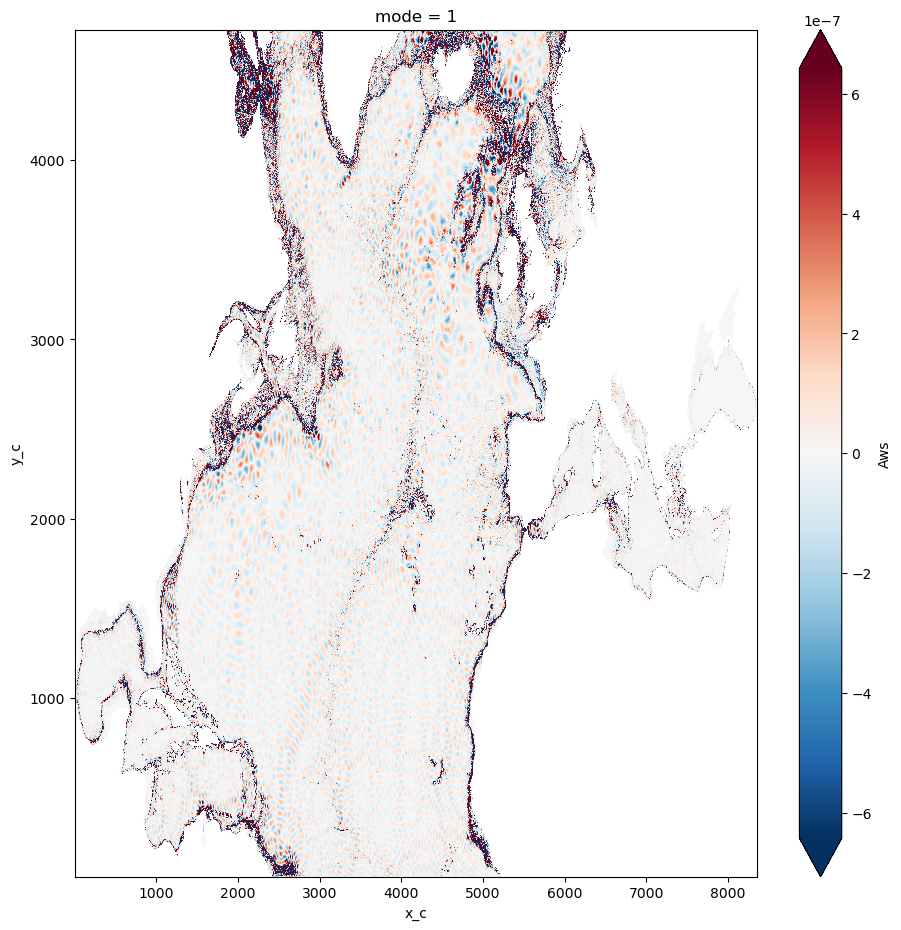

In [25]:
%%time
cluster.scale(jobs=large_computation_nodes_number)

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (11, 11)

wn = xr.open_zarr(datapath_data_preprocessed/"Aws_{}.zarr".format(Month))
wn = wn.Aws.isel({d:slice(0, None,2) for d in ["t"]})
wn.real.isel(mode=1).mean(dim='t', skipna=True).plot(robust=True)

